In [0]:
import tarfile
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.metrics import *
import collections
from PIL import Image
from random import shuffle 
from sklearn.model_selection import train_test_split

In [0]:
def unzip(path):
  tar = tarfile.open(path)
  tar.extractall()
  tar.close

In [0]:
unzip('face.train.tar.gz')
unzip('face.test.tar.gz')

In [0]:
face_train = glob.glob("train/face/*.pgm")
non_face_train = glob.glob("train/non-face/*.pgm")
face_test = glob.glob("test/face/*.pgm")
non_face_test = glob.glob("test/non-face/*.pgm")

In [0]:
face_img_data = cv2.imread(face_test[1], cv2.IMREAD_COLOR)

In [0]:
def create_label(image_name):
  
  if 'face' in image_name:
    return np.array([1,0])
  else:
    return np.array([0,1])

In [0]:
def create_data(name):

  if name == 'train':
    training_data = []
    for train_face_img in face_train:
      train_face_img_data = cv2.imread(train_face_img, cv2.IMREAD_COLOR)
      training_data.append([np.array(train_face_img_data), np.array([1,0])]) #change np.array to create_label funtion to change label values

    for train_non_face_img in non_face_train:
      train_non_face_img_data = cv2.imread(train_non_face_img, cv2.IMREAD_COLOR)
      training_data.append([np.array(train_non_face_img_data), np.array([0,1])]) #change np.array to create_label funtion to change label values
    shuffle(training_data)
    return training_data

  if name == 'test':
    testing_data = []
    for test_face_img in face_test:
      test_face_img_data = cv2.imread(test_face_img, cv2.IMREAD_COLOR)
      testing_data.append([np.array(test_face_img)])

    for test_non_face_img in non_face_test:
      test_non_face_img_data = cv2.imread(test_non_face_img, cv2.IMREAD_COLOR)
      testing_data.append([np.array(test_non_face_img)])
    shuffle(testing_data)
    return testing_data    

In [0]:
train = create_data('train')
test = create_data('test')

In [0]:
train_data = [i[0] for i in train]
labels = [i[1] for i in train]

In [0]:
X_train, X_val, y_train, y_val = train_test_split(train_data, labels, test_size=0.3, random_state=1234) 

In [10]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
%matplotlib inline

In [0]:
tf.reset_default_graph()

In [0]:
MODEL_NAME = 'face-vs-nonface-convnet'

In [14]:
print(X_train[1].shape)

(19, 19, 3)


In [15]:
convnet = input_data(shape = [None, 19, 19, 3], name = 'input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=1e-3, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose=0)

model.fit({'input': X_train},
          {'targets': y_train},
          n_epoch=5,
          validation_set=({'input':X_train}, {'targets':y_train}),
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 384  | total loss: 0.05879 | time: 2.726s
| Adam | epoch: 005 | loss: 0.05879 - acc: 0.9814 -- iter: 4864/4883
Training Step: 385  | total loss: 0.05591 | time: 3.896s
| Adam | epoch: 005 | loss: 0.05591 - acc: 0.9817 | val_loss: 0.03952 - val_acc: 0.9883 -- iter: 4883/4883
--


In [16]:
d = np.array(X_val[3:4])
d.shape

(1, 19, 19, 3)

Face


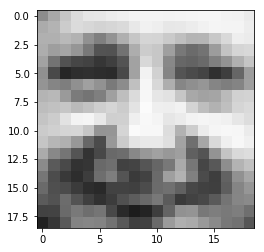

In [17]:
prediction = model.predict(d)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(X_val[3], cmap="plasma")
if prediction[0,0] > prediction[0,1]:
  print('\033[1m' + "Face" + '\033[0m')
else:
  print('\033[1m' + "Non Face" + '\033[0m')